In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, LinearSVC, FMClassifier, GBTClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
os.environ["JAVA_HOME"] = "D:\Miniconda\envs\spark_env\Library\lib\jvm"  
os.environ["SPARK_HOME"] = "D:\Miniconda\envs\spark_env\Lib\site-packages\pyspark"  
os.environ["PYSPARK_PYTHON"] = "D:\Miniconda\envs\spark_env\python.exe"  
os.environ['PYSPARK_DRIVER_PYTHON'] = r'D:\Miniconda\envs\spark_env\python.exe'


In [3]:
import os
print("JAVA_HOME:", os.environ.get("JAVA_HOME"))
print("SPARK_HOME:", os.environ.get("SPARK_HOME"))
print("PYSPARK_PYTHON:", os.environ.get("PYSPARK_PYTHON"))


JAVA_HOME: D:\Miniconda\envs\spark_env\Library\lib\jvm
SPARK_HOME: D:\Miniconda\envs\spark_env\Lib\site-packages\pyspark
PYSPARK_PYTHON: D:\Miniconda\envs\spark_env\python.exe


In [4]:
spark = SparkSession.builder.appName('bank_customer_churn').getOrCreate()

In [5]:
df = spark.read.csv(r"D:\school_work\Bank-Customer-Churn-Prediction-using-PySpark-main\new_train.csv", 
                    inferSchema=True, 
                    header=True)
display(df)

DataFrame[id: int, CustomerId: int, Surname: string, CreditScore: int, Geography: string, Gender: string, Age: double, Tenure: int, Balance: double, NumOfProducts: int, HasCrCard: double, IsActiveMember: double, EstimatedSalary: double, Exited: int]

In [6]:
df.count()

31408

In [7]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: double (nullable = true)
 |-- IsActiveMember: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [8]:
df.show(5)

+------+----------+-------+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+------+
|    id|CustomerId|Surname|CreditScore|Geography|Gender| Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+------+----------+-------+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+------+
| 89698|  15689661|  Hsing|        685|   France|Female|33.0|     8|      0.0|            2|      1.0|           0.0|      166466.19|     0|
| 29194|  15664734|  T'ien|        576|   France|  Male|30.0|     8|      0.0|            2|      0.0|           1.0|      136886.86|     0|
|160152|  15754849|   Zito|        707|   France|Female|41.0|     3|      0.0|            1|      1.0|           0.0|      101694.67|     1|
|107266|  15803689|   Shih|        613|   France|  Male|39.0|     6|      0.0|            1|      1.0|           0.0|       49553.38|     0|
| 67973|  155

In [9]:
df.describe().collect()

[Row(summary='count', id='31408', CustomerId='31408', Surname='31408', CreditScore='31408', Geography='31408', Gender='31408', Age='31408', Tenure='31408', Balance='31408', NumOfProducts='31408', HasCrCard='31408', IsActiveMember='31408', EstimatedSalary='31408', Exited='31408'),
 Row(summary='mean', id='82898.5422822211', CustomerId='1.5692735979081763E7', Surname=None, CreditScore='655.2139900662252', Geography=None, Gender=None, Age='37.97860417727967', Tenure='5.019135252165054', Balance='54059.92601311741', NumOfProducts='1.5692817116658175', HasCrCard='0.7565906775343861', IsActiveMember='0.5045211411105451', EstimatedSalary='112179.84626974032', Exited='0.18552598064187467'),
 Row(summary='stddev', id='47397.081254288096', CustomerId='71418.37064365705', Surname=None, CreditScore='80.33601480870891', Geography=None, Gender=None, Age='8.818067934305532', Tenure='2.797443782393311', Balance='62572.19203380965', NumOfProducts='0.5473487302584391', HasCrCard='0.4291469304357098', Is

In [10]:
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+---+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
| id|CustomerId|Surname|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+
|  0|         0|      0|          0|        0|     0|  0|     0|      0|            0|        0|             0|              0|     0|
+---+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+



In [11]:
df_grouped = df.groupBy(df.columns).count() # Group by all columns and count occurrences
duplicates = df_grouped.where("count>1") # Filter rows where count > 1 which indicates the presence of duplicate records in the dataset
duplicates.show()

+---+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+-----+
| id|CustomerId|Surname|CreditScore|Geography|Gender|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|count|
+---+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+-----+
+---+----------+-------+-----------+---------+------+---+------+-------+-------------+---------+--------------+---------------+------+-----+



In [12]:
df.createOrReplaceTempView("customers")

In [13]:
%load_ext sql

In [14]:
# %sql select * from customers;

In [15]:
result = spark.sql("SELECT * FROM customers")
result.show()

+------+----------+-----------+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+------+
|    id|CustomerId|    Surname|CreditScore|Geography|Gender| Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+------+----------+-----------+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+------+
| 89698|  15689661|      Hsing|        685|   France|Female|33.0|     8|      0.0|            2|      1.0|           0.0|      166466.19|     0|
| 29194|  15664734|      T'ien|        576|   France|  Male|30.0|     8|      0.0|            2|      0.0|           1.0|      136886.86|     0|
|160152|  15754849|       Zito|        707|   France|Female|41.0|     3|      0.0|            1|      1.0|           0.0|      101694.67|     1|
|107266|  15803689|       Shih|        613|   France|  Male|39.0|     6|      0.0|            1|      1.0|           0.0|       49

In [16]:
result_pd = result.toPandas()
result_pd.head()  

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,89698,15689661,Hsing,685,France,Female,33.0,8,0.00,2,1.0,0.0,166466.19,0
1,29194,15664734,T'ien,576,France,Male,30.0,8,0.00,2,0.0,1.0,136886.86,0
2,160152,15754849,Zito,707,France,Female,41.0,3,0.00,1,1.0,0.0,101694.67,1
3,107266,15803689,Shih,613,France,Male,39.0,6,0.00,1,1.0,0.0,49553.38,0
4,67973,15591035,Nworie,683,Germany,Male,46.0,1,126817.65,1,1.0,0.0,182988.94,1


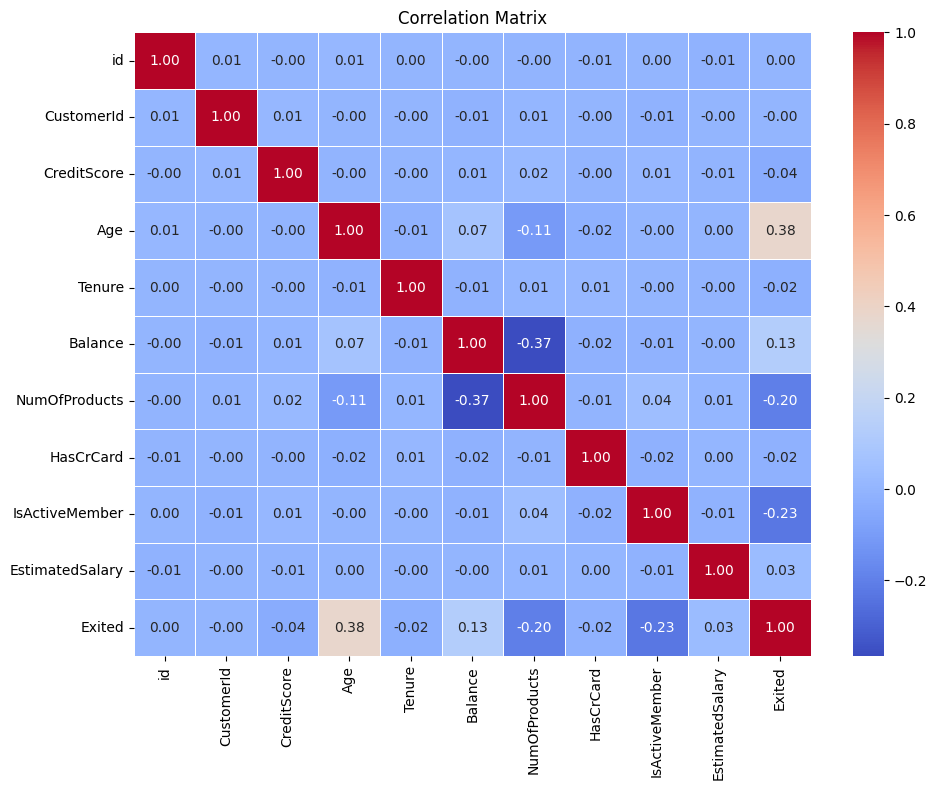

In [17]:
numeric_columns = result_pd.select_dtypes(include=[float, int]).columns
correlation_matrix = result_pd[numeric_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [18]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: double (nullable = true)
 |-- IsActiveMember: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [19]:
df.groupBy('id').count().show(5)

+-----+-----+
|   id|count|
+-----+-----+
|29194|    1|
|31261|    1|
|89476|    1|
|63645|    1|
|26623|    1|
+-----+-----+
only showing top 5 rows



In [20]:
df.groupBy('CustomerId').count().orderBy('count',ascending=False).show(5)

+----------+-----+
|CustomerId|count|
+----------+-----+
|  15682355|   29|
|  15690164|   22|
|  15798895|   22|
|  15585835|   21|
|  15793331|   21|
+----------+-----+
only showing top 5 rows



In [21]:
df.groupBy('Surname').count().orderBy('count',ascending=False).count()

2110

In [22]:
indexer = StringIndexer(inputCols=["Geography","Gender"],outputCols=["Geography_Index","Gender_Index"])
assembler = VectorAssembler(inputCols=["CreditScore","Age","Tenure","Balance","NumOfProducts","HasCrCard","IsActiveMember","EstimatedSalary","Geography_Index","Gender_Index"],outputCol='features')
scaler = StandardScaler(inputCol="features",outputCol="scaledFeatures")

In [23]:
data_prep_pipeline = Pipeline(stages=[indexer,assembler,scaler]) # Create a data preparation pipeline to convert it into a format suitable for machine learning models
data_prep_pipeline

Pipeline_e3793502725c

In [24]:
spark1 = SparkSession.builder \
    .appName('bank_customer_churn') \
    .config("spark.sql.catalogImplementation", "hive") \
    .enableHiveSupport() \
    .getOrCreate()

In [25]:
df.createOrReplaceTempView("temp_customers")
spark1.sql("CREATE DATABASE IF NOT EXISTS bank")
spark1.sql("USE bank")
spark1.sql("DROP TABLE IF EXISTS customers")
df.write.mode("overwrite").saveAsTable("bank.customers")

In [26]:
from pyspark.ml.feature import StringIndexer
gender_indexer = StringIndexer(inputCol="Gender", outputCol="GenderIndex")
df_with_gender_index = gender_indexer.fit(df).transform(df)
df_with_gender_index.createOrReplaceTempView("customers")

In [27]:
correlation_results = spark.sql("""
    SELECT 
        CORR(CreditScore, Exited) AS credit_score_corr,
        CORR(Age, Exited) AS age_corr,
        CORR(Balance, Exited) AS balance_corr,
        CORR(EstimatedSalary, Exited) AS salary_corr,
        CORR(GenderIndex, Exited) AS gender_corr
    FROM customers
""")
correlation_results.show()

+--------------------+------------------+-------------------+--------------------+-------------------+
|   credit_score_corr|          age_corr|       balance_corr|         salary_corr|        gender_corr|
+--------------------+------------------+-------------------+--------------------+-------------------+
|-0.03527690357353881|0.3774873611642467|0.12661487702471205|0.030038325108217596|0.15951519863879113|
+--------------------+------------------+-------------------+--------------------+-------------------+



C:\Users\ShenKe\AppData\Local\Temp\ipykernel_25284\1539918286.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


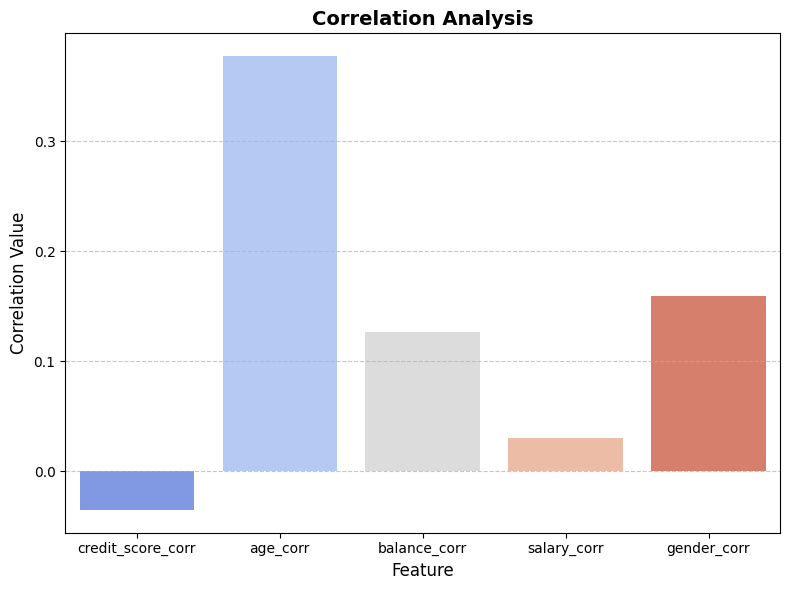

In [28]:
correlation_df = correlation_results.toPandas()
correlation_df_melted = correlation_df.melt(var_name="Feature", value_name="Correlation")
plt.figure(figsize=(8, 6))
sns.barplot(
    x="Feature",
    y="Correlation",
    data=correlation_df_melted,
    palette=sns.color_palette("coolwarm", len(correlation_df_melted))
)
plt.title("Correlation Analysis", fontsize=14, fontweight="bold")
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Correlation Value", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.tight_layout()  
plt.show()

In [29]:
hypothesis_test = spark.sql("""
    SELECT 
        Age_Group,
        COUNT(*) AS total_customers,
        SUM(CASE WHEN Exited = 1 THEN 1 ELSE 0 END) AS churn_count,
        (SUM(CASE WHEN Exited = 1 THEN 1 ELSE 0 END) * 1.0 / COUNT(*)) AS churn_rate
    FROM (
        SELECT *,
               CASE 
                   WHEN Age < 30 THEN 'Under 30'
                   WHEN Age BETWEEN 30 AND 50 THEN '30-50'
                   ELSE 'Above 50'
               END AS Age_Group
        FROM customers
    ) subquery
    GROUP BY Age_Group
""")
hypothesis_test.show()

+---------+---------------+-----------+------------------+
|Age_Group|total_customers|churn_count|        churn_rate|
+---------+---------------+-----------+------------------+
|    30-50|          24068|       4083|0.1696443410337377|
| Above 50|           2795|       1492|0.5338103756708408|
| Under 30|           4545|        252|0.0554455445544554|
+---------+---------------+-----------+------------------+



C:\Users\ShenKe\AppData\Local\Temp\ipykernel_25284\1552693663.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Age_Group", y="churn_rate", data=hypothesis_test_df, palette="Blues_d")


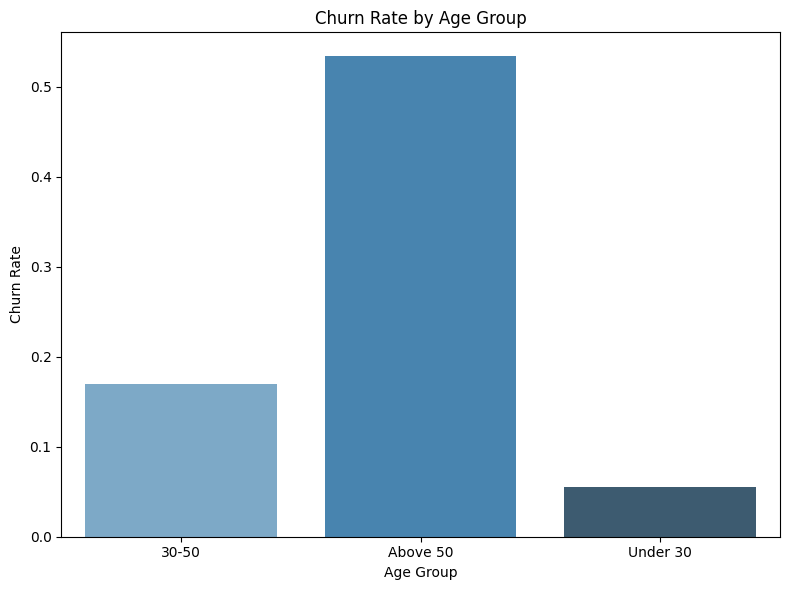

In [30]:
hypothesis_test_df = hypothesis_test.toPandas()
plt.figure(figsize=(8, 6))
sns.barplot(x="Age_Group", y="churn_rate", data=hypothesis_test_df, palette="Blues_d")
plt.title("Churn Rate by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Churn Rate")
plt.tight_layout()  
plt.show()

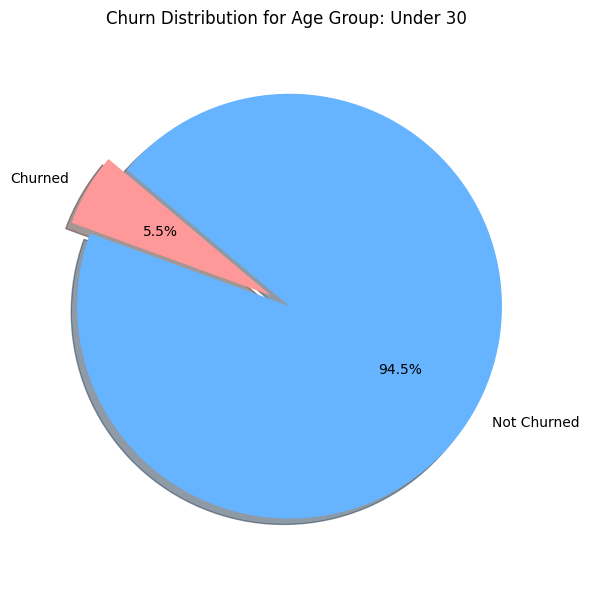

In [31]:
age_group_data = hypothesis_test_df[hypothesis_test_df['Age_Group'] == 'Under 30']
churn_count = age_group_data['churn_count'].values[0]
total_count = age_group_data['total_customers'].values[0]
not_churn_count = total_count - churn_count
labels = ['Churned', 'Not Churned']
sizes = [churn_count, not_churn_count]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Churn Distribution for Age Group: Under 30')
plt.axis('equal')  
plt.tight_layout()
plt.show()

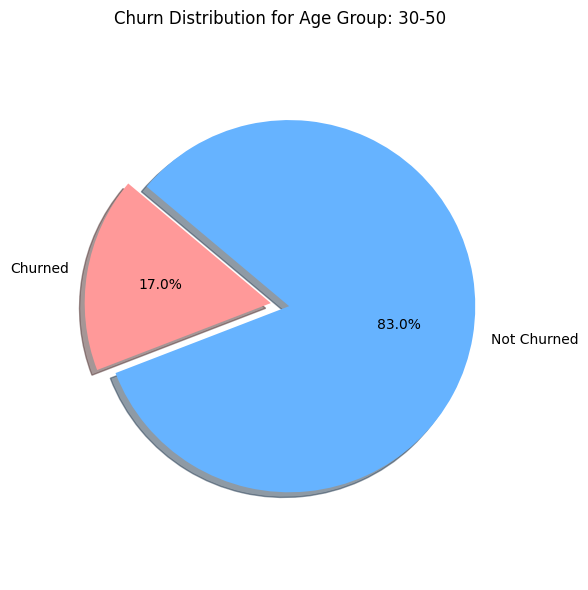

In [32]:
age_group_data = hypothesis_test_df[hypothesis_test_df['Age_Group'] == '30-50']
churn_count = age_group_data['churn_count'].values[0]
total_count = age_group_data['total_customers'].values[0]
not_churn_count = total_count - churn_count
labels = ['Churned', 'Not Churned']
sizes = [churn_count, not_churn_count]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Churn Distribution for Age Group: 30-50')
plt.axis('equal') 
plt.tight_layout()
plt.show()

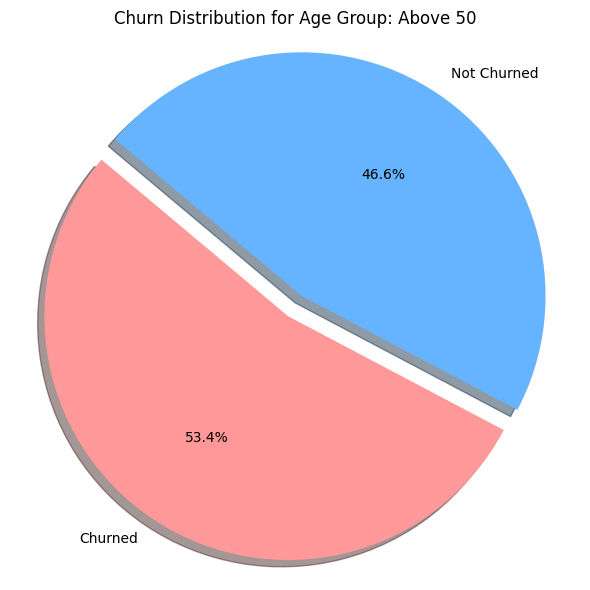

In [33]:
age_group_data = hypothesis_test_df[hypothesis_test_df['Age_Group'] == 'Above 50']
churn_count = age_group_data['churn_count'].values[0]
total_count = age_group_data['total_customers'].values[0]
not_churn_count = total_count - churn_count
labels = ['Churned', 'Not Churned']
sizes = [churn_count, not_churn_count]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Churn Distribution for Age Group: Above 50')
plt.axis('equal')  
plt.tight_layout()
plt.show()

In [34]:
desc_stats = spark.sql("""
    SELECT 
        AVG(CreditScore) AS avg_credit_score,
        MIN(CreditScore) AS min_credit_score,
        MAX(CreditScore) AS max_credit_score,
        STDDEV(CreditScore) AS stddev_credit_score,

        AVG(Age) AS avg_age,
        MIN(Age) AS min_age,
        MAX(Age) AS max_age,
        STDDEV(Age) AS stddev_age,

        AVG(Balance) AS avg_balance,
        MIN(Balance) AS min_balance,
        MAX(Balance) AS max_balance,
        STDDEV(Balance) AS stddev_balance,

        AVG(EstimatedSalary) AS avg_estimated_salary,
        MIN(EstimatedSalary) AS min_estimated_salary,
        MAX(EstimatedSalary) AS max_estimated_salary,
        STDDEV(EstimatedSalary) AS stddev_estimated_salary,

        COUNT(*) AS total_customers
    FROM customers
""")
desc_stats.show()

+-----------------+----------------+----------------+-------------------+-----------------+-------+-------+-----------------+-----------------+-----------+-----------+-----------------+--------------------+--------------------+--------------------+-----------------------+---------------+
| avg_credit_score|min_credit_score|max_credit_score|stddev_credit_score|          avg_age|min_age|max_age|       stddev_age|      avg_balance|min_balance|max_balance|   stddev_balance|avg_estimated_salary|min_estimated_salary|max_estimated_salary|stddev_estimated_salary|total_customers|
+-----------------+----------------+----------------+-------------------+-----------------+-------+-------+-----------------+-----------------+-----------+-----------+-----------------+--------------------+--------------------+--------------------+-----------------------+---------------+
|655.2139900662252|             350|             850|  80.33601480870891|37.97860417727967|   18.0|   92.0|8.818067934305532|54059.92

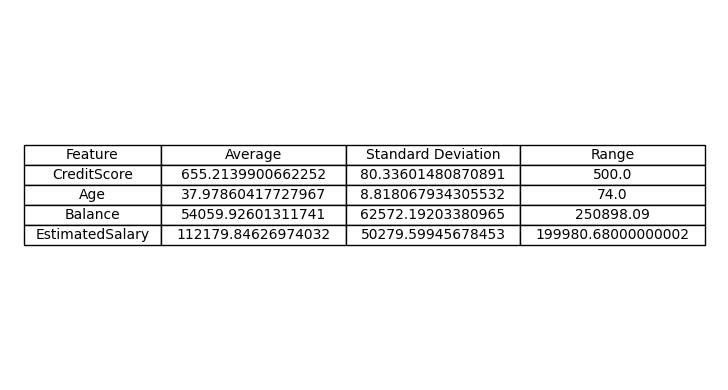

In [35]:
desc_stats_pd = desc_stats.toPandas()
desc_stats_pd['range_credit_score'] = desc_stats_pd['max_credit_score'] - desc_stats_pd['min_credit_score']
desc_stats_pd['range_age'] = desc_stats_pd['max_age'] - desc_stats_pd['min_age']
desc_stats_pd['range_balance'] = desc_stats_pd['max_balance'] - desc_stats_pd['min_balance']
desc_stats_pd['range_estimated_salary'] = desc_stats_pd['max_estimated_salary'] - desc_stats_pd['min_estimated_salary']
table_data = {
    "Feature": [
        "CreditScore", "Age", "Balance", "EstimatedSalary"
    ],
    "Average": [
        desc_stats_pd['avg_credit_score'][0],
        desc_stats_pd['avg_age'][0],
        desc_stats_pd['avg_balance'][0],
        desc_stats_pd['avg_estimated_salary'][0]
    ],
    "Standard Deviation": [
        desc_stats_pd['stddev_credit_score'][0],
        desc_stats_pd['stddev_age'][0],
        desc_stats_pd['stddev_balance'][0],
        desc_stats_pd['stddev_estimated_salary'][0]
    ],
    "Range": [
        desc_stats_pd['range_credit_score'][0],
        desc_stats_pd['range_age'][0],
        desc_stats_pd['range_balance'][0],
        desc_stats_pd['range_estimated_salary'][0]
    ]
}

summary_table = pd.DataFrame(table_data)

fig, ax = plt.subplots(figsize=(8, 4))  
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=summary_table.values, colLabels=summary_table.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([0, 1, 2, 3])  

plt.tight_layout()
plt.show()

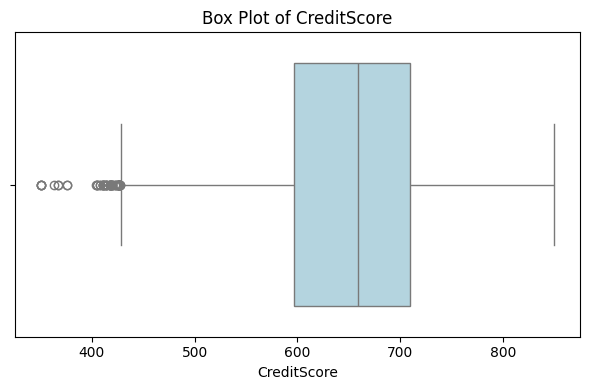

In [36]:
pandas_df = df.select('CreditScore', 'Age', 'Balance', 'EstimatedSalary').toPandas()
plt.figure(figsize=(6, 4))
sns.boxplot(x=pandas_df['CreditScore'], color='lightblue')
plt.title('Box Plot of CreditScore')
plt.tight_layout()
plt.show()

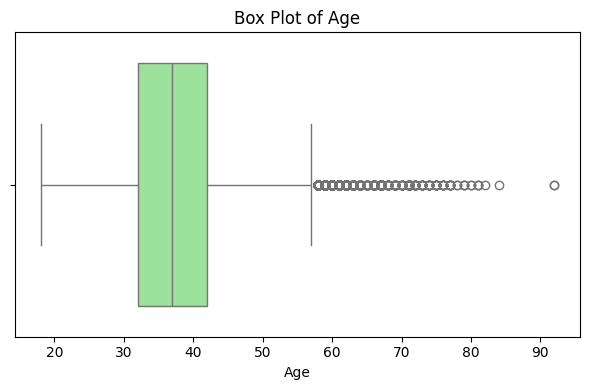

In [37]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=pandas_df['Age'], color='lightgreen')
plt.title('Box Plot of Age')
plt.tight_layout()
plt.show()

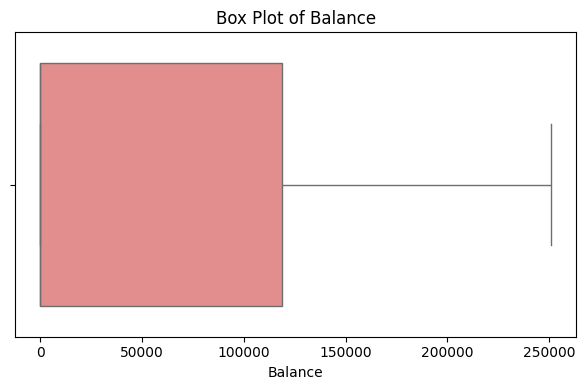

In [38]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=pandas_df['Balance'], color='lightcoral')
plt.title('Box Plot of Balance')
plt.tight_layout()
plt.show()

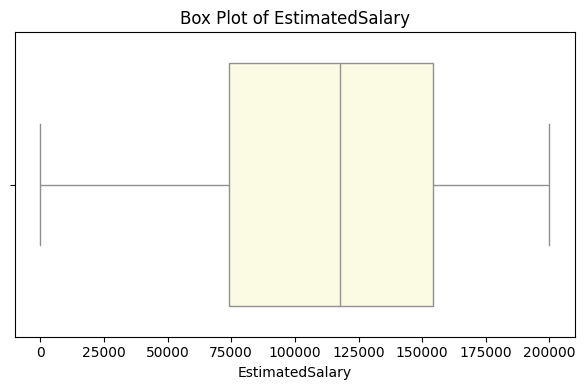

In [39]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=pandas_df['EstimatedSalary'], color='lightyellow')
plt.title('Box Plot of EstimatedSalary')
plt.tight_layout()
plt.show()

In [40]:
density_query = spark.sql("""
    SELECT 
        Gender,
        COUNT(*) AS frequency
    FROM customers
    GROUP BY Gender
    ORDER BY Gender
""")
density_query.show()

+------+---------+
|Gender|frequency|
+------+---------+
|Female|    13522|
|  Male|    17886|
+------+---------+



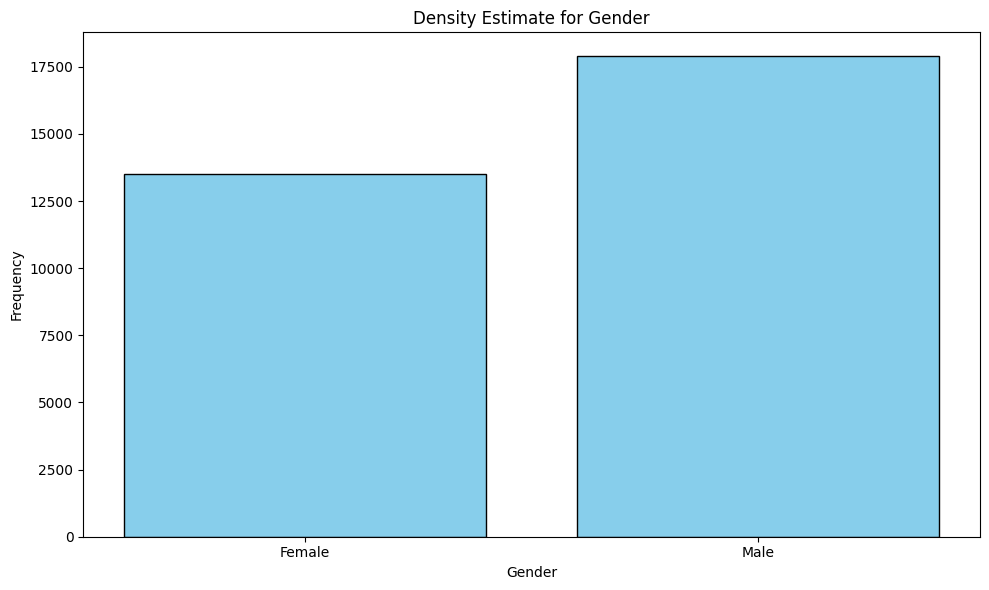

In [41]:
density_data = density_query.collect()
genders = [row['Gender'] for row in density_data]
frequencies = [row['frequency'] for row in density_data]
plt.figure(figsize=(10, 6))
plt.bar(genders, frequencies, color='skyblue', edgecolor='black')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Density Estimate for Gender')
plt.tight_layout()
plt.show()

In [42]:
country_stats = spark.sql("""
    SELECT 
        Geography AS Country,
        COUNT(*) AS Total_Customers,
        SUM(CASE WHEN Exited = 1 THEN 1 ELSE 0 END) AS Churned_Customers,
        ROUND(SUM(CASE WHEN Exited = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS Churn_Rate
    FROM customers
    GROUP BY Geography
    ORDER BY Total_Customers DESC
""")

country_stats.show()

+-------+---------------+-----------------+----------+
|Country|Total_Customers|Churned_Customers|Churn_Rate|
+-------+---------------+-----------------+----------+
| France|          18101|             2523|     13.94|
|  Spain|           6967|             1019|     14.63|
|Germany|           6340|             2285|     36.04|
+-------+---------------+-----------------+----------+



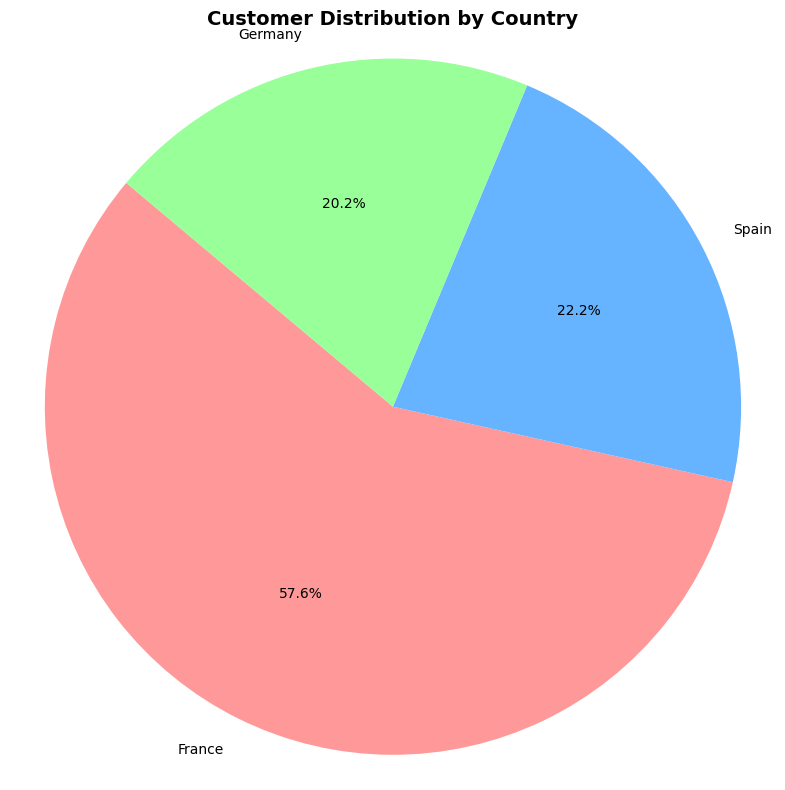

In [43]:
country_stats_pd = country_stats.toPandas()
colors_country = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', '#C4E17F', '#FFB7DD']
colors_churned = ['#FFC1C1', '#8FCFFF', '#D3FFCE', '#FFE4B5', '#D2FFD2', '#FFCCE5']

plt.figure(figsize=(8, 8))
plt.pie(
    country_stats_pd['Total_Customers'],
    labels=country_stats_pd['Country'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors_country
)
plt.title('Customer Distribution by Country', fontsize=14, fontweight='bold')
plt.axis('equal') 
plt.tight_layout()
plt.show()

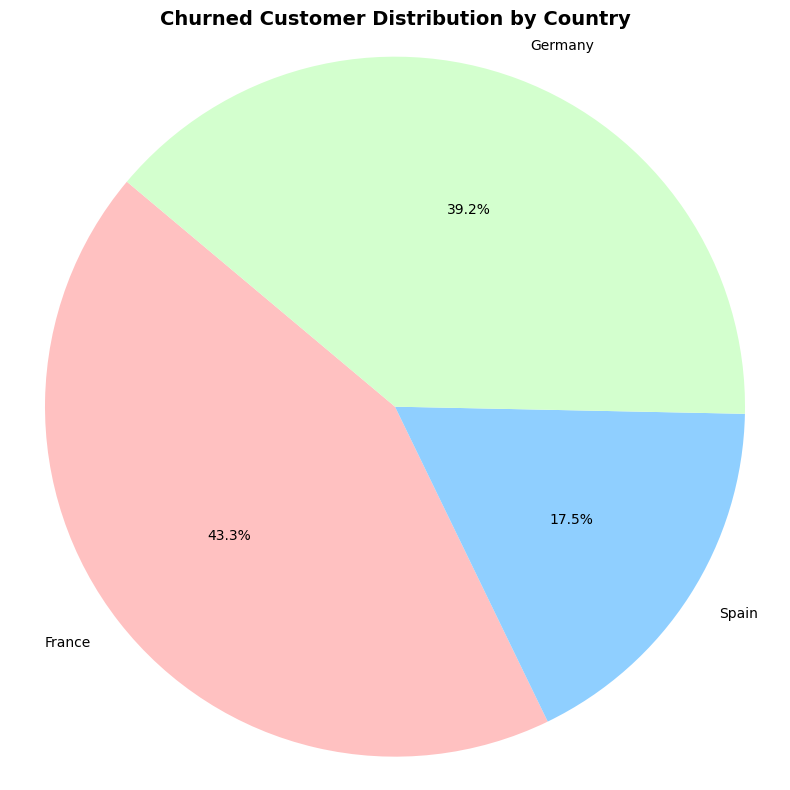

In [44]:
plt.figure(figsize=(8, 8))
plt.pie(
    country_stats_pd['Churned_Customers'],
    labels=country_stats_pd['Country'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors_churned
)
plt.title('Churned Customer Distribution by Country', fontsize=14, fontweight='bold')
plt.axis('equal')  
plt.tight_layout()
plt.show()

In [45]:
salary_stage_analysis = spark.sql("""
    SELECT 
        Salary_Stage,
        COUNT(*) AS Total_Customers,
        SUM(CASE WHEN Exited = 1 THEN 1 ELSE 0 END) AS Churned_Customers,
        ROUND(SUM(CASE WHEN Exited = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS Churn_Rate
    FROM (
        SELECT *,
               CASE 
                   WHEN EstimatedSalary < 50000 THEN 'Low Salary'
                   WHEN EstimatedSalary BETWEEN 50000 AND 100000 THEN 'Mid Salary'
                   ELSE 'High Salary'
               END AS Salary_Stage
        FROM customers
    ) subquery
    GROUP BY Salary_Stage
    ORDER BY Total_Customers DESC
""")

salary_stage_analysis.show()

+------------+---------------+-----------------+----------+
|Salary_Stage|Total_Customers|Churned_Customers|Churn_Rate|
+------------+---------------+-----------------+----------+
| High Salary|          18661|             3616|     19.38|
|  Mid Salary|           8876|             1568|     17.67|
|  Low Salary|           3871|              643|     16.61|
+------------+---------------+-----------------+----------+



C:\Users\ShenKe\AppData\Local\Temp\ipykernel_25284\113239857.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


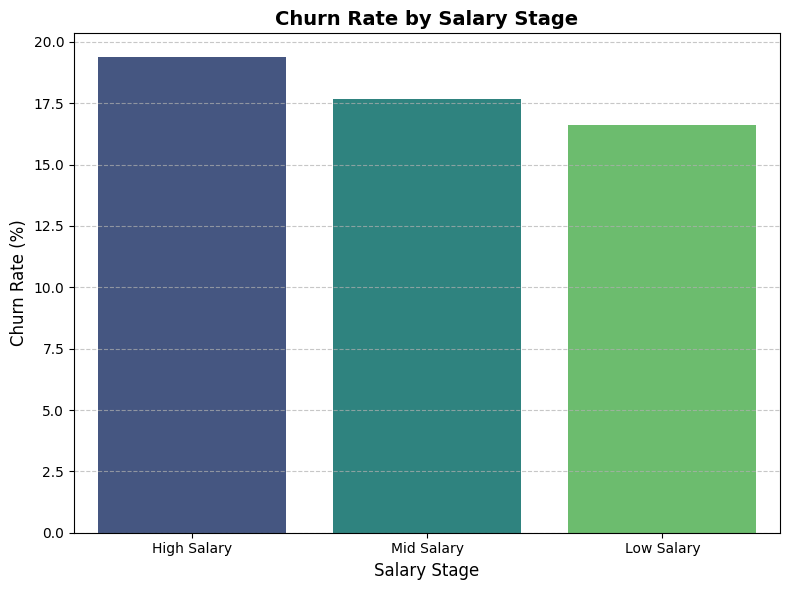

In [46]:
salary_stage_analysis_pd = salary_stage_analysis.toPandas()
plt.figure(figsize=(8, 6))
sns.barplot(
    x="Salary_Stage",
    y="Churn_Rate",
    data=salary_stage_analysis_pd,
    palette="viridis"
)
plt.title("Churn Rate by Salary Stage", fontsize=14, fontweight="bold")
plt.xlabel("Salary Stage", fontsize=12)
plt.ylabel("Churn Rate (%)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [47]:
tenure_analysis = spark.sql("""
    SELECT 
        Tenure,
        COUNT(*) AS Total_Customers,
        SUM(CASE WHEN Exited = 1 THEN 1 ELSE 0 END) AS Churned_Customers,
        ROUND(SUM(CASE WHEN Exited = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS Churn_Rate
    FROM customers
    GROUP BY Tenure
    ORDER BY Tenure
""")
tenure_analysis.show()

+------+---------------+-----------------+----------+
|Tenure|Total_Customers|Churned_Customers|Churn_Rate|
+------+---------------+-----------------+----------+
|     0|            941|              206|     21.89|
|     1|           3189|              632|     19.82|
|     2|           3409|              599|     17.57|
|     3|           3127|              617|     19.73|
|     4|           3425|              668|     19.50|
|     5|           3284|              675|     20.55|
|     6|           3036|              514|     16.93|
|     7|           3398|              561|     16.51|
|     8|           3379|              575|     17.02|
|     9|           3101|              563|     18.16|
|    10|           1119|              217|     19.39|
+------+---------------+-----------------+----------+



C:\Users\ShenKe\AppData\Local\Temp\ipykernel_25284\1313559609.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


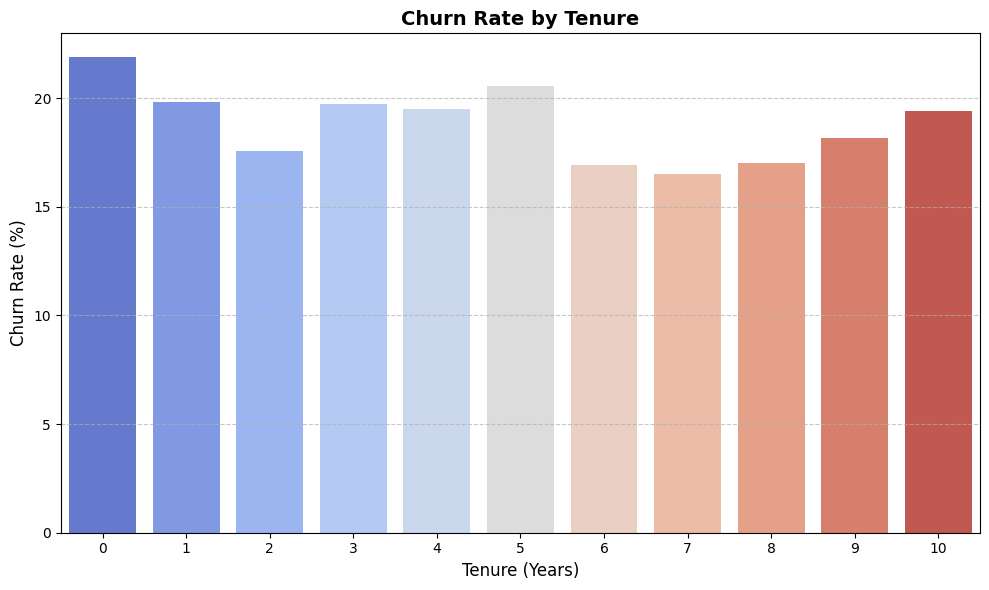

In [48]:
tenure_analysis_pd = tenure_analysis.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Tenure",
    y="Churn_Rate",
    data=tenure_analysis_pd,
    palette="coolwarm"
)
plt.title("Churn Rate by Tenure", fontsize=14, fontweight="bold")
plt.xlabel("Tenure (Years)", fontsize=12)
plt.ylabel("Churn Rate (%)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [49]:
fitted_data_prep_pipeline = data_prep_pipeline.fit(df)
final_df = fitted_data_prep_pipeline.transform(df)
final_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: double (nullable = true)
 |-- IsActiveMember: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)
 |-- Geography_Index: double (nullable = false)
 |-- Gender_Index: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)



In [50]:
train_df, test_df = final_df.randomSplit([0.7,0.3],seed=42)


In [51]:
model_names = []
models = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

In [52]:
def train_and_evaluate_model(model):
    clf = model.fit(train_df)
    results = clf.transform(test_df)
    roc_eval = BinaryClassificationEvaluator(labelCol="Exited",metricName="areaUnderROC")
    pr_eval = BinaryClassificationEvaluator(labelCol="Exited",metricName="areaUnderPR")
    acc_eval = MulticlassClassificationEvaluator(labelCol="Exited",metricName="accuracy")
    prec_eval = MulticlassClassificationEvaluator(labelCol="Exited",metricName="weightedPrecision")
    recall_eval = MulticlassClassificationEvaluator(labelCol="Exited",metricName="weightedRecall")
    f1_eval = MulticlassClassificationEvaluator(labelCol="Exited",metricName="f1")
    print(f"Area under ROC AUC Curve: {roc_eval.evaluate(results): .3f}")
    print(f"Area under PR Curve: {pr_eval.evaluate(results): .3f}")
    print(f"Accuracy: {acc_eval.evaluate(results): .3f}")
    print(f"Weighted Precision: {prec_eval.evaluate(results): .3f}")
    print(f"Weighted Recall: {recall_eval.evaluate(results): .3f}")
    print(f"F1 Score: {f1_eval.evaluate(results): .3f}")
    model_names.append(str(model).split('(')[0])
    accuracy_scores.append(acc_eval.evaluate(results))
    precision_scores.append(prec_eval.evaluate(results))
    recall_scores.append(recall_eval.evaluate(results))
    f1_scores.append(f1_eval.evaluate(results))
    roc_auc_scores.append(roc_eval.evaluate(results))
    models.append(clf)

In [53]:
train_and_evaluate_model(LogisticRegression(labelCol='Exited',featuresCol='scaledFeatures'))

Area under ROC AUC Curve:  0.849
Area under PR Curve:  0.629
Accuracy:  0.870
Weighted Precision:  0.860
Weighted Recall:  0.870
F1 Score:  0.857


In [54]:
train_and_evaluate_model(NaiveBayes(labelCol='Exited',featuresCol='scaledFeatures'))

Area under ROC AUC Curve:  0.448
Area under PR Curve:  0.171
Accuracy:  0.827
Weighted Precision:  0.800
Weighted Recall:  0.827
F1 Score:  0.800


In [55]:
train_and_evaluate_model(DecisionTreeClassifier(labelCol='Exited',featuresCol='scaledFeatures'))

Area under ROC AUC Curve:  0.576
Area under PR Curve:  0.529
Accuracy:  0.891
Weighted Precision:  0.887
Weighted Recall:  0.891
F1 Score:  0.881


In [56]:
train_and_evaluate_model(RandomForestClassifier(labelCol='Exited',featuresCol='scaledFeatures'))

Area under ROC AUC Curve:  0.915
Area under PR Curve:  0.770
Accuracy:  0.897
Weighted Precision:  0.892
Weighted Recall:  0.897
F1 Score:  0.890


In [57]:
train_and_evaluate_model(LinearSVC(labelCol='Exited',featuresCol='scaledFeatures'))

Area under ROC AUC Curve:  0.846
Area under PR Curve:  0.634
Accuracy:  0.870
Weighted Precision:  0.861
Weighted Recall:  0.870
F1 Score:  0.855


In [58]:
train_and_evaluate_model(GBTClassifier(labelCol='Exited',featuresCol='scaledFeatures'))

Area under ROC AUC Curve:  0.925
Area under PR Curve:  0.797
Accuracy:  0.909
Weighted Precision:  0.905
Weighted Recall:  0.909
F1 Score:  0.905


In [59]:
train_and_evaluate_model(FMClassifier(labelCol='Exited',featuresCol='scaledFeatures'))

Area under ROC AUC Curve:  0.826
Area under PR Curve:  0.627
Accuracy:  0.827
Weighted Precision:  0.844
Weighted Recall:  0.827
F1 Score:  0.762


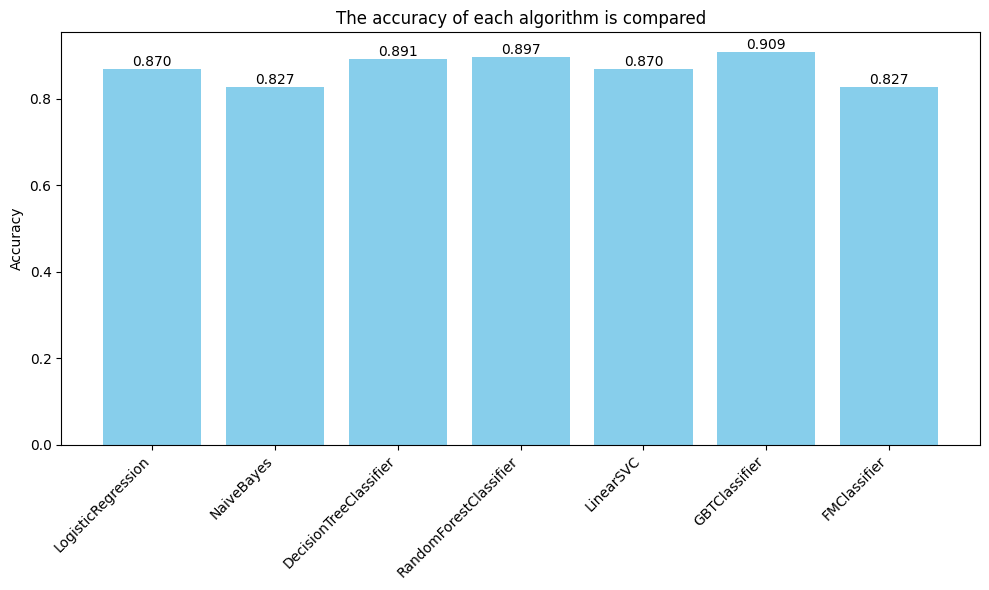

In [60]:
model_names = ['LogisticRegression', 'NaiveBayes', 'DecisionTreeClassifier', 'RandomForestClassifier',
               'LinearSVC', 'GBTClassifier', 'FMClassifier']  


plt.figure(figsize=(10,6))

indices = np.arange(len(model_names))
bars = plt.bar(indices, accuracy_scores, color='skyblue')

for bar, acc in zip(bars, accuracy_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{acc:.3f}', ha='center', va='bottom')
plt.xticks(indices, model_names, rotation=45, ha="right")  
plt.ylabel('Accuracy')
plt.title('The accuracy of each algorithm is compared')


plt.tight_layout()
plt.show()

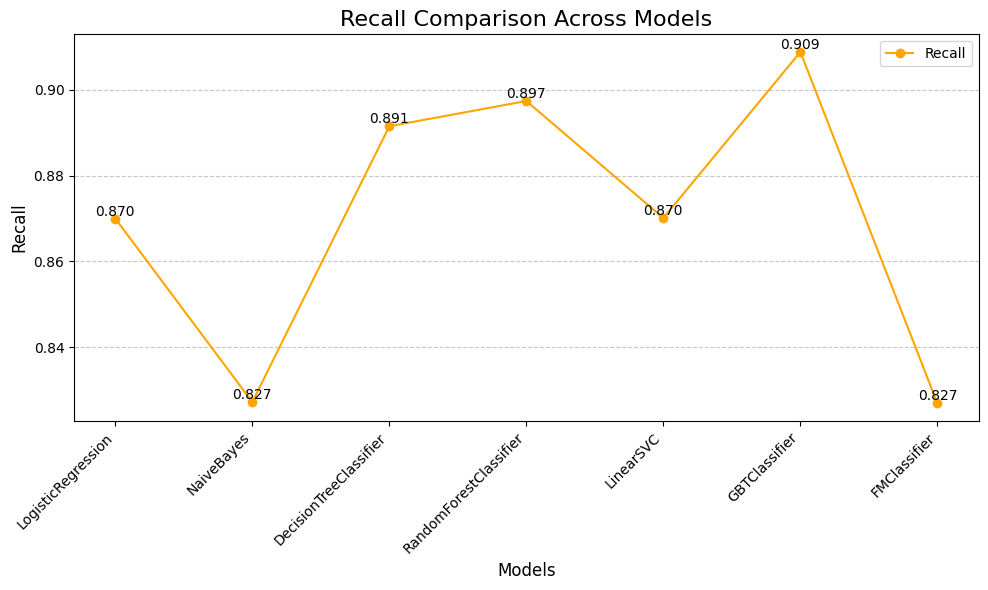

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(model_names, recall_scores, marker='o', linestyle='-', color='orange', label='Recall')
for i, recall in enumerate(recall_scores):
    plt.text(i, recall, f'{recall:.3f}', ha='center', va='bottom', fontsize=10)
plt.title('Recall Comparison Across Models', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.xticks(rotation=45, ha="right")  
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.legend()

plt.tight_layout()
plt.show()

In [62]:
spark = SparkSession.builder \
    .appName("YourAppName") \
    .config("spark.executor.memory", "6g") \
    .config("spark.driver.memory", "6g") \
    .getOrCreate()


In [63]:
spark = SparkSession.builder \
    .appName("YourAppName") \
    .config("spark.python.worker.reuse", "true") \
    .config("spark.python.worker.timeout", "600") \
    .getOrCreate()



In [64]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("YourAppName") \
    .config("spark.driver.extraJavaOptions", "-Dio.netty.tryReflectionSetAccessible=true") \
    .config("spark.executor.extraJavaOptions", "-Dio.netty.tryReflectionSetAccessible=true") \
    .getOrCreate()



In [65]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

gbt = GBTClassifier(labelCol='Exited', featuresCol='scaledFeatures')

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5, 7]) \
    .addGrid(gbt.maxIter, [10, 20, 50]) \
    .addGrid(gbt.stepSize, [0.05, 0.1, 0.2]) \
    .build()

evaluator = BinaryClassificationEvaluator(labelCol="Exited", metricName="areaUnderROC")

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  

cvModel = crossval.fit(train_df)

bestModel = cvModel.bestModel
results = bestModel.transform(test_df)
print(f"Best MaxDepth: {bestModel.getMaxDepth()}")
print(f"Best MaxIter: {bestModel.getMaxIter()}")
print(f"Best StepSize: {bestModel.getStepSize()}")
print(f"Area under ROC: {evaluator.evaluate(results):.2f}")

Best MaxDepth: 3
Best MaxIter: 50
Best StepSize: 0.2
Area under ROC: 0.93


In [66]:
lr = LogisticRegression(labelCol='Exited',featuresCol='scaledFeatures')

param_grid = ParamGridBuilder() \
                .addGrid(lr.regParam,[0.01,0.1,1.0]) \
                .addGrid(lr.elasticNetParam,[0.0,0.5,1.0]) \
                .build()

acc_eval = MulticlassClassificationEvaluator(labelCol='Exited',metricName='accuracy')
prec_eval = MulticlassClassificationEvaluator(labelCol='Exited',metricName='weightedPrecision')
recall_eval = MulticlassClassificationEvaluator(labelCol='Exited',metricName='weightedRecall')
f1_eval = MulticlassClassificationEvaluator(labelCol='Exited',metricName='f1')
roc_auc_eval = BinaryClassificationEvaluator(labelCol='Exited',metricName='areaUnderROC')
area_under_pr_eval = BinaryClassificationEvaluator(labelCol='Exited',metricName='areaUnderPR')

lr_cv = CrossValidator(estimator=lr,
                       evaluator=acc_eval,
                       estimatorParamMaps=param_grid,
                       numFolds=4) # Number of cross validation folds

fitted_lr = lr_cv.fit(train_df)
results = fitted_lr.transform(test_df)
print("Test set accuracy: " + str(acc_eval.evaluate(results)))
print("Test set weighted precision: " + str(prec_eval.evaluate(results)))
print("Test set weighted recall: " + str(recall_eval.evaluate(results)))
print("Test set F1: " + str(f1_eval.evaluate(results)))
print("Test set area under ROC: " + str(roc_auc_eval.evaluate(results)))
print("Test set area under PR: " + str(area_under_pr_eval.evaluate(results)))

Test set accuracy: 0.8648792992950224
Test set weighted precision: 0.8541006589372742
Test set weighted recall: 0.8648792992950225
Test set F1: 0.8484823296964603
Test set area under ROC: 0.8493503861672868
Test set area under PR: 0.627014746037963


In [67]:
fitted_lr.bestModel

LogisticRegressionModel: uid=LogisticRegression_78fbf1cf91f1, numClasses=2, numFeatures=10

In [68]:
fitted_lr.bestModel.getElasticNetParam()

0.0

In [69]:
fitted_lr.bestModel.getRegParam()

0.01

In [70]:
dtc = DecisionTreeClassifier(labelCol='Exited',featuresCol='scaledFeatures')

paramGrid = ParamGridBuilder() \
            .addGrid(dtc.impurity, ['gini','entropy']) \
            .addGrid(dtc.maxDepth,[2,6,12,18]) \
            .addGrid(dtc.minInstancesPerNode, [1, 2, 4]) \
            .build()

acc_eval = MulticlassClassificationEvaluator(labelCol='Exited',metricName='accuracy')
prec_eval = MulticlassClassificationEvaluator(labelCol='Exited',metricName='weightedPrecision')
recall_eval = MulticlassClassificationEvaluator(labelCol='Exited',metricName='weightedRecall')
f1_eval = MulticlassClassificationEvaluator(labelCol='Exited',metricName='f1')
roc_auc_eval = BinaryClassificationEvaluator(labelCol='Exited',metricName='areaUnderROC')
area_under_pr_eval = BinaryClassificationEvaluator(labelCol='Exited',metricName='areaUnderPR')

dtc_cv = CrossValidator(estimator=dtc,
                       evaluator=acc_eval,
                       estimatorParamMaps=param_grid,
                       numFolds=4) # Number of cross validation folds

fitted_dtc = dtc_cv.fit(train_df)
results = fitted_dtc.transform(test_df)
print("Test set accuracy: " + str(acc_eval.evaluate(results)))
print("Test set weighted precision: " + str(prec_eval.evaluate(results)))
print("Test set weighted recall: " + str(recall_eval.evaluate(results)))
print("Test set F1: " + str(f1_eval.evaluate(results)))
print("Test set area under ROC: " + str(roc_auc_eval.evaluate(results)))
print("Test set area under PR: " + str(area_under_pr_eval.evaluate(results)))

Test set accuracy: 0.891476180303354
Test set weighted precision: 0.8867658508478874
Test set weighted recall: 0.891476180303354
Test set F1: 0.8813313545463596
Test set area under ROC: 0.575627955015956
Test set area under PR: 0.529242834845807


In [71]:
fitted_dtc.bestModel

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_f3608cd61298, depth=5, numNodes=21, numClasses=2, numFeatures=10

In [72]:
fitted_dtc.bestModel.getImpurity()

'gini'

In [73]:
fitted_dtc.bestModel.getMaxDepth()

5

In [74]:
fitted_dtc.bestModel.getMinInstancesPerNode()

1

In [75]:
rfc = RandomForestClassifier(labelCol='Exited',featuresCol='scaledFeatures')

paramGrid = ParamGridBuilder() \
            .addGrid(rfc.numTrees, [20,50,100]) \
            .addGrid(rfc.impurity,['gini','entropy']) \
            .addGrid(rfc.maxDepth,[2,6,12,18]) \
            .addGrid(rfc.featureSubsetStrategy,['auto','all','onethird','sqrt','log2']) \
            .addGrid(rfc.bootstrap,[True,False]) \
            .build()

acc_eval = MulticlassClassificationEvaluator(labelCol='Exited',metricName='accuracy')
prec_eval = MulticlassClassificationEvaluator(labelCol='Exited',metricName='weightedPrecision')
recall_eval = MulticlassClassificationEvaluator(labelCol='Exited',metricName='weightedRecall')
f1_eval = MulticlassClassificationEvaluator(labelCol='Exited',metricName='f1')
roc_auc_eval = BinaryClassificationEvaluator(labelCol='Exited',metricName='areaUnderROC')
area_under_pr_eval = BinaryClassificationEvaluator(labelCol='Exited',metricName='areaUnderPR')

rfc_cv = CrossValidator(estimator=rfc,
                       evaluator=acc_eval,
                       estimatorParamMaps=param_grid,
                       numFolds=3) # Number of cross validation folds

fitted_rfc = rfc_cv.fit(train_df)
results = fitted_rfc.transform(test_df)
print("Test set accuracy: " + str(acc_eval.evaluate(results)))
print("Test set weighted precision: " + str(prec_eval.evaluate(results)))
print("Test set weighted recall: " + str(recall_eval.evaluate(results)))
print("Test set F1: " + str(f1_eval.evaluate(results)))
print("Test set area under ROC: " + str(roc_auc_eval.evaluate(results)))
print("Test set area under PR: " + str(area_under_pr_eval.evaluate(results)))

Test set accuracy: 0.8973509933774835
Test set weighted precision: 0.8924051045584078
Test set weighted recall: 0.8973509933774834
Test set F1: 0.8899884649611713
Test set area under ROC: 0.9152766603083905
Test set area under PR: 0.7700865989082993


In [76]:
fitted_rfc.bestModel

RandomForestClassificationModel: uid=RandomForestClassifier_f58bbd8f7ade, numTrees=20, numClasses=2, numFeatures=10

In [77]:
fitted_rfc.bestModel.getImpurity()

'gini'

In [78]:
fitted_rfc.bestModel.getFeatureSubsetStrategy()

'auto'

In [79]:
fitted_rfc.bestModel.getMaxDepth()

5

In [80]:
fitted_rfc.bestModel.getBootstrap()

True

In [81]:
svc = LinearSVC(labelCol='Exited',featuresCol='scaledFeatures')

param_grid = ParamGridBuilder() \
                .addGrid(svc.regParam,[0.01,0.1,1.0]) \
                .build()

acc_eval = MulticlassClassificationEvaluator(labelCol='Exited',metricName='accuracy')
prec_eval = MulticlassClassificationEvaluator(labelCol='Exited',metricName='weightedPrecision')
recall_eval = MulticlassClassificationEvaluator(labelCol='Exited',metricName='weightedRecall')
f1_eval = MulticlassClassificationEvaluator(labelCol='Exited',metricName='f1')
roc_auc_eval = BinaryClassificationEvaluator(labelCol='Exited',metricName='areaUnderROC')
area_under_pr_eval = BinaryClassificationEvaluator(labelCol='Exited',metricName='areaUnderPR')

svc_cv = CrossValidator(estimator=svc,
                       evaluator=acc_eval,
                       estimatorParamMaps=param_grid,
                       numFolds=4) # Number of cross validation folds

fitted_svc = svc_cv.fit(train_df)
results = fitted_svc.transform(test_df)
print("Test set accuracy: " + str(acc_eval.evaluate(results)))
print("Test set weighted precision: " + str(prec_eval.evaluate(results)))
print("Test set weighted recall: " + str(recall_eval.evaluate(results)))
print("Test set F1: " + str(f1_eval.evaluate(results)))
print("Test set area under ROC: " + str(roc_auc_eval.evaluate(results)))
print("Test set area under PR: " + str(area_under_pr_eval.evaluate(results)))

Test set accuracy: 0.8670155949583422
Test set weighted precision: 0.8576724730709904
Test set weighted recall: 0.8670155949583422
Test set F1: 0.8497421620181937
Test set area under ROC: 0.8468821850770374
Test set area under PR: 0.6314270079418198


In [82]:
fitted_svc.bestModel

LinearSVCModel: uid=LinearSVC_74a50d92f35e, numClasses=2, numFeatures=10

In [83]:
fitted_svc.bestModel.getRegParam()

0.01

In [84]:
nb = NaiveBayes(labelCol='Exited',featuresCol='scaledFeatures')

param_grid = ParamGridBuilder() \
                .addGrid(nb.smoothing,[0.0,0.5,1.0]) \
                .build()

acc_eval = MulticlassClassificationEvaluator(labelCol='Exited',metricName='accuracy')
prec_eval = MulticlassClassificationEvaluator(labelCol='Exited',metricName='weightedPrecision')
recall_eval = MulticlassClassificationEvaluator(labelCol='Exited',metricName='weightedRecall')
f1_eval = MulticlassClassificationEvaluator(labelCol='Exited',metricName='f1')
roc_auc_eval = BinaryClassificationEvaluator(labelCol='Exited',metricName='areaUnderROC')
area_under_pr_eval = BinaryClassificationEvaluator(labelCol='Exited',metricName='areaUnderPR')

nb_cv = CrossValidator(estimator=nb,
                       evaluator=acc_eval,
                       estimatorParamMaps=param_grid,
                       numFolds=4) # Number of cross validation folds

fitted_nb = nb_cv.fit(train_df)
results = fitted_nb.transform(test_df)
print("Test set accuracy: " + str(acc_eval.evaluate(results)))
print("Test set weighted precision: " + str(prec_eval.evaluate(results)))
print("Test set weighted recall: " + str(recall_eval.evaluate(results)))
print("Test set F1: " + str(f1_eval.evaluate(results)))
print("Test set area under ROC: " + str(roc_auc_eval.evaluate(results)))
print("Test set area under PR: " + str(area_under_pr_eval.evaluate(results)))

Test set accuracy: 0.8272804956205939
Test set weighted precision: 0.7997339402240732
Test set weighted recall: 0.8272804956205939
Test set F1: 0.7999296882900304
Test set area under ROC: 0.44792414366688654
Test set area under PR: 0.17122254482503163


In [85]:
fitted_nb.bestModel

NaiveBayesModel: uid=NaiveBayes_82425fcfd0d0, modelType=multinomial, numClasses=2, numFeatures=10

In [86]:
fitted_nb.bestModel.getSmoothing()

0.0

In [87]:
models

[LogisticRegressionModel: uid=LogisticRegression_cb04b71a48d9, numClasses=2, numFeatures=10,
 NaiveBayesModel: uid=NaiveBayes_37df5a4db1b3, modelType=multinomial, numClasses=2, numFeatures=10,
 DecisionTreeClassificationModel: uid=DecisionTreeClassifier_765a7b7c46af, depth=5, numNodes=21, numClasses=2, numFeatures=10,
 RandomForestClassificationModel: uid=RandomForestClassifier_0f1e8e0dafb6, numTrees=20, numClasses=2, numFeatures=10,
 LinearSVCModel: uid=LinearSVC_dbc0d7e31565, numClasses=2, numFeatures=10,
 GBTClassificationModel: uid = GBTClassifier_ac550fbcbb9a, numTrees=20, numClasses=2, numFeatures=10,
 FMClassificationModel: uid=FMClassifier_560cac9d4624, numClasses=2, numFeatures=10, factorSize=8, fitLinear=true, fitIntercept=true]

In [89]:
spark = SparkSession.builder \
    .appName("YourAppName") \
    .master("local[*]") \
    .getOrCreate()


In [90]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
models[-2].save(r"D:\school_work\myresult")

In [92]:
models[-2]

GBTClassificationModel: uid = GBTClassifier_ac550fbcbb9a, numTrees=20, numClasses=2, numFeatures=10

In [93]:
loaded_model = GBTClassificationModel.load(r"D:\school_work\myresult")
loaded_model

GBTClassificationModel: uid = GBTClassifier_ac550fbcbb9a, numTrees=20, numClasses=2, numFeatures=10

In [94]:
test_df = spark.read.csv(r"D:\school_work\Bank-Customer-Churn-Prediction-using-PySpark-main\new_test.csv",inferSchema=True,header=True)
test_df.show(5)

+---+----------+---------+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+------+
| id|CustomerId|  Surname|CreditScore|Geography|Gender| Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---+----------+---------+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+------+
| 20|  15781496|Udegbulam|        773|    Spain|  Male|35.0|     9|      0.0|            2|      0.0|           1.0|       87549.36|     0|
| 35|  15661591|Panicucci|        413|  Germany|  Male|28.0|     3|130969.77|            2|      1.0|           1.0|      158891.79|     0|
| 44|  15643671|Chiekwugo|        773|   France|  Male|36.0|     8| 77253.22|            2|      1.0|           1.0|       35817.97|     0|
| 49|  15645353|    Chubb|        607|   France|  Male|26.0|     1|      0.0|            2|      1.0|           0.0|        29818.2|     0|
| 96|  15671139|    

In [95]:
cleaned_test_df = fitted_data_prep_pipeline.transform(test_df) # transform the test data using the feature transformation pipeline

In [96]:
cleaned_test_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: double (nullable = true)
 |-- IsActiveMember: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)
 |-- Geography_Index: double (nullable = false)
 |-- Gender_Index: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)



In [97]:
test_results = loaded_model.transform(cleaned_test_df)

In [98]:
test_results.printSchema()

root
 |-- id: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: double (nullable = true)
 |-- IsActiveMember: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)
 |-- Geography_Index: double (nullable = false)
 |-- Gender_Index: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [99]:
predictions = test_results.select("prediction")
predictions.show()

+----------+
|prediction|
+----------+
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
|       1.0|
|       1.0|
|       0.0|
|       0.0|
|       1.0|
|       0.0|
|       0.0|
|       0.0|
|       0.0|
+----------+
only showing top 20 rows



In [100]:
true_label_column = "Exited"
print("Test Results Schema:")
test_results.printSchema()
results_df = test_results.select("prediction", true_label_column).withColumnRenamed("prediction", "predicted_label")
results_df.show(5)  
results_pd = results_df.select("predicted_label", true_label_column).toPandas()
print("Converted Pandas DataFrame:")
print(results_pd.head())
y_true = results_pd[true_label_column]
y_pred = results_pd["predicted_label"]

print("True Labels:", y_true.unique())
print("Predicted Labels:", y_pred.unique())

accuracy = accuracy_score(y_true, y_pred)

print(f"acc: {accuracy:.2f}")

conf_matrix = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

Test Results Schema:
root
 |-- id: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: double (nullable = true)
 |-- IsActiveMember: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)
 |-- Geography_Index: double (nullable = false)
 |-- Gender_Index: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

+---------------+------+
|predicted_label|Exited|
+---------------+------+
|            0.0

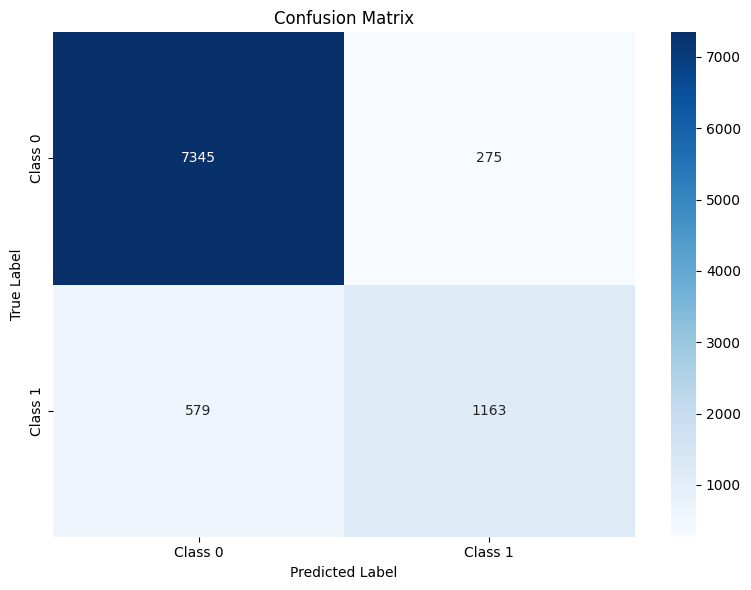

In [101]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [103]:
from pyspark.sql.functions import mean, pow, abs, col

test_results = test_results.withColumnRenamed("prediction", "predicted_label")

mse = test_results.select(mean(pow(col("predicted_label") - col(true_label_column), 2)).alias("mse")).collect()[0]["mse"]
print(f"MSE: {mse:.4f}")

rmse = mse ** 0.5
print(f"RMSE: {rmse:.4f}")

mae = test_results.select(mean(abs(col("predicted_label") - col(true_label_column))).alias("mae")).collect()[0]["mae"]
print(f"MAE: {mae:.4f}")

mean_actual = test_results.select(mean(col(true_label_column)).alias("mean_actual")).collect()[0]["mean_actual"]
ss_total = test_results.select(pow(col(true_label_column) - mean_actual, 2).alias("ss_total")).agg({"ss_total": "sum"}).collect()[0]["sum(ss_total)"]
ss_residual = test_results.select(pow(col(true_label_column) - col("predicted_label"), 2).alias("ss_residual")).agg({"ss_residual": "sum"}).collect()[0]["sum(ss_residual)"]
r2 = 1 - (ss_residual / ss_total)
print(f"R²: {r2:.4f}")

MSE: 0.0912
RMSE: 0.3020
MAE: 0.0912
R²: 0.3977


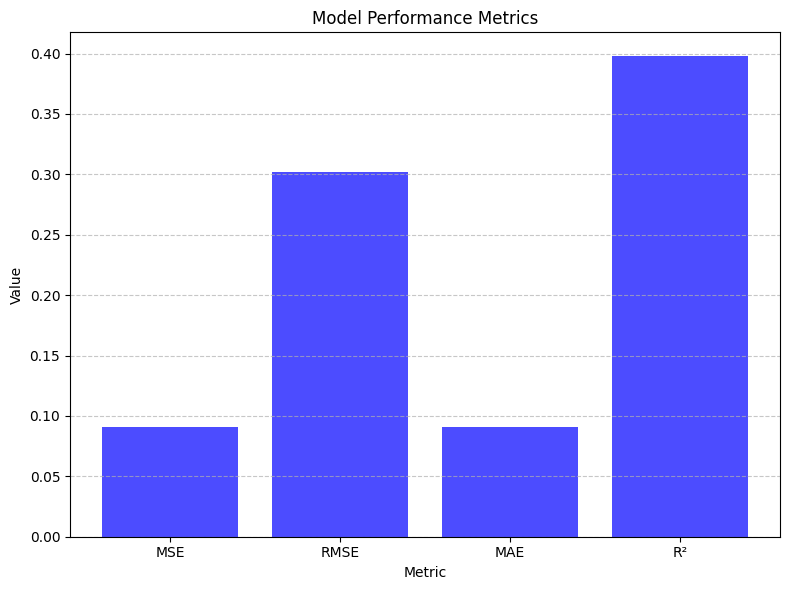

In [105]:
metrics = ['MSE', 'RMSE', 'MAE', 'R²']
values = [mse, rmse, mae, r2]
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color='b', alpha=0.7)
plt.title("Model Performance Metrics")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()